# Setup

In [1]:
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10,6]

train_csv = pd.read_csv('train.csv')
valid_csv = pd.read_csv('dev.csv')
whole_csv = pd.concat([train_csv, valid_csv], axis=0, ignore_index=True)

In [2]:
def preliminary_feature(data):
    data['user_review_count'] = data.sort_values(['user_id','date']).groupby('user_id')['ex_id'].cumcount()
    data['user_average_rating'] = data.sort_values(['user_id', 'date']).groupby('user_id')['rating'].cumsum() \
                                  / (data['user_review_count'] + 1)
    data['restaurant_review_count'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['ex_id'].cumcount()
    data['restaurant_average_rating'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['rating'].cumsum() \
                                        / (data['restaurant_review_count'] + 1)
    data['wordcount'] = data['review'].str.count(" ")
    first_user_review = data.groupby('user_id')['date'].min()
    data['days_since_first_user'] = (pd.to_datetime(data.set_index('user_id')['date']) \
                                     - pd.to_datetime(first_user_review))\
                                    .dt.days.reset_index(drop=True)
    first_restaurant_review = data.groupby('prod_id')['date'].min()
    data['days_since_first_restaurant'] = (pd.to_datetime(data.set_index('prod_id')['date']) \
                                           - pd.to_datetime(first_restaurant_review)) \
                                          .dt.days.reset_index(drop=True)
    data['punctuation_count'] = data['review'].str.count('[,;:!.]')
    data['capitalization_count'] = data['review'].str.count('[A-Z]+')
    data['letter_count'] = data['review'].str.len()
    
    return data

In [3]:
whole = preliminary_feature(whole_csv)

In [4]:
train = whole[:250874]
print("Original:", len(train_csv), "FE:", len(train))

Original: 250874 FE: 250874


In [5]:
valid = whole[250874:].reset_index()
print("Original:", len(valid_csv), "FE:", len(valid))

Original: 35918 FE: 35918


In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(pred, y, label, title=None):
    precision, recall, _ = precision_recall_curve(y, pred)
    aps = average_precision_score(y_true=y, y_score=pred)
    
    plt.step(recall, precision, alpha=0.2,
             where='post',
             label='{}: Average Precision = {:0.3f}'.format(label, aps))
    plt.fill_between(recall, precision, step='post', alpha=0.2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if title is None:
        title = 'Precision-Recall Curve'
    plt.title(title)
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

#### ↓ Prediction from MultinomialNB - TFIDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [8]:
cv = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(train['review'].tolist())
text_data_valid = cv.transform(valid['review'].tolist())

print(text_data_train.shape)
print(text_data_valid.shape)

(250874, 4701)
(35918, 4701)


C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


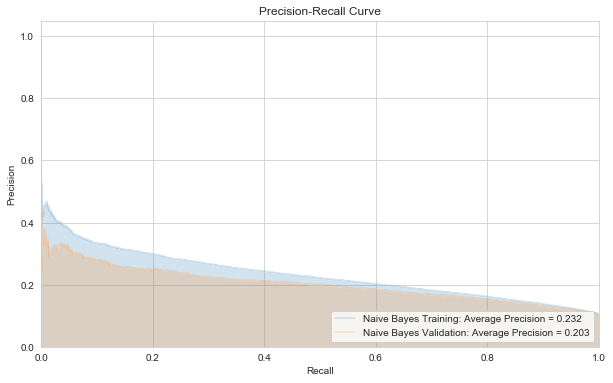

In [9]:
nb = MultinomialNB()
nb.fit(text_data_train, train['label'])

train['pred_nb'] = nb.predict_proba(text_data_train)[:,1]
valid['pred_nb'] = nb.predict_proba(text_data_valid)[:,1]

plot_pr(train['pred_nb'], train['label'], label='Naive Bayes Training')
plot_pr(valid['pred_nb'], valid['label'], label='Naive Bayes Validation')

#### ↓ Word2Vec using Gensim

In [10]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [11]:
documents_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(train['review'].str.split(" "))]

In [12]:
d2v = Doc2Vec(documents_train, vector_size=32, window=2, min_count=100)

In [13]:
d2v_df_train = train['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_train.columns = ['d2v_' + str(x) for x in d2v_df_train.columns]

In [14]:
d2v_df_valid = valid['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_valid.columns = ['d2v_' + str(x) for x in d2v_df_valid.columns]

#### ↓ Putting everything together

In [15]:
train_features = ['rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                  'restaurant_average_rating',
                  'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                  'days_since_first_user', 'days_since_first_restaurant']

In [16]:
everything_train = pd.concat([train, d2v_df_train], axis=1)
everything_valid = pd.concat([valid, d2v_df_valid], axis=1)

### ↓ previously spammed or not

In [17]:
everything_train['spammed'] = train.sort_values(['user_id','date']).groupby('user_id')['label'].cumsum() > 1

train_spammers = everything_train[everything_train.spammed==True][['user_id', 'spammed']].drop_duplicates()
everything_valid = everything_valid.merge(train_spammers, how='left', on='user_id')
everything_valid['spammed'] = everything_valid['spammed'].fillna(False)

In [18]:
train_features = ['rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                 'restaurant_average_rating',
                 'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                 'days_since_first_user', 'days_since_first_restaurant']

y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()
everything_features = train_features + ['pred_nb'] + d2v_df_train.columns.tolist() + ['spammed']

everything_model = XGBClassifier(scale_pos_weight=pos_ratio, max_depth=4, reg_alpha=10, reg_lambda=5, random_state=42)
everything_model.fit(everything_train[everything_features], y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=10,
              reg_lambda=5, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


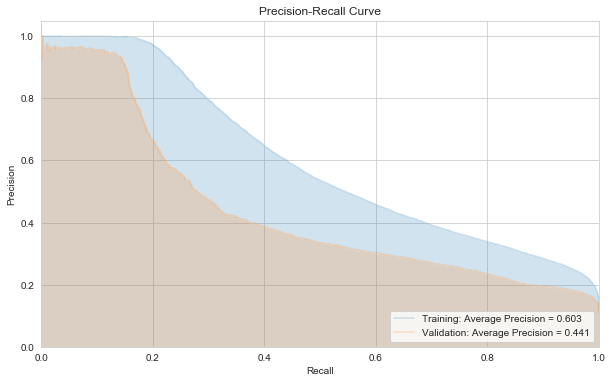

In [19]:
train['pred_id'] = everything_model.predict_proba(everything_train[everything_features])[:,1]
valid['pred_id'] = everything_model.predict_proba(everything_valid[everything_features])[:,1]

plot_pr(train['pred_id'], train['label'], label='Training')
plot_pr(valid['pred_id'], valid['label'], label='Validation')

### Test Set

In [20]:
# load test set 
test_csv = pd.read_csv('test_no_label.csv').sort_values('ex_id')
whole_csv = pd.concat([train_csv, test_csv], axis=0, ignore_index=True)

In [21]:
# Apply preliminary_feature
whole = preliminary_feature(whole_csv)
test = whole[250874:].reset_index()

In [22]:
# MNB prediction on test
text_data_test = cv.transform(test['review'].tolist())
test['pred_nb'] = nb.predict_proba(text_data_test)[:,1]

In [23]:
# Word2Vec using Gensim
d2v_df_test = test['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_test.columns = ['d2v_' + str(x) for x in d2v_df_test.columns]

In [24]:
everything_test = pd.concat([test, d2v_df_test], axis=1)
everything_test = everything_test.merge(train_spammers, how='left', on='user_id')
everything_test['spammed'] = everything_test['spammed'].fillna(False)

In [25]:
predictions = everything_model.predict(everything_test[everything_features], output_margin=True)

In [26]:
pd.DataFrame(predictions).to_csv('predictions.csv', index=False, header=False)

※ Appendix

In [27]:
from collections import Counter
spammer = set(train[train.label==1].user_id)
nonspammer = set(train[train.label==0].user_id)
print("number of ppl spam in training:", len(spammer))
print("number of ppl not spam in training:", len(nonspammer))
print("number of ppl spam n not spam:", len(spammer.intersection(nonspammer)))
print("prop. of spammers who make fake review only:", round((len(spammer)-len(spammer.intersection(nonspammer))) / len(spammer), 2))

number of ppl spam in training: 21006
number of ppl not spam in training: 105074
number of ppl spam n not spam: 401
prop. of spammers who make fake review only: 0.98
